In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
import joblib
import numpy as np
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
data = pd.read_csv("/kaggle/input/fakenewscorpus/preprocessed_data.csv")

# Splitting into X (features) and y (target)
X = data['content']
y = data['label']

In [4]:
# Data Splitting to Train, Validation and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
# TF-IDF Vectorization
def custom_tokenizer(text):
    # convert to lowercase, remove punctuation and numeric data, then tokenize
    text = text.lower()
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    tokens = word_tokenize(text)
    return tokens


vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_features=3000, norm="l2")
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['tfidf_vectorizer.pkl']

In [6]:
# Define MLPClassifier model
mlp_classifier = MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                               activation='relu',
                               alpha=0.001,  # L2 regularization parameter
                               solver='adam',
                               batch_size=128,
                               learning_rate='adaptive',
                               max_iter=10,
                               random_state=42,
                               early_stopping=True,  # Enable early stopping to prevent overfitting
                               validation_fraction=0.1,  # Validation set size for early stopping
                               n_iter_no_change=10,  # Number of epochs with no improvement to stop training
                               verbose=True
                               )

# Train the MLPClassifier model
mlp_classifier.fit(X_train_vec, y_train)

Iteration 1, loss = 0.25661257
Validation score: 0.895506
Iteration 2, loss = 0.20739873
Validation score: 0.900520
Iteration 3, loss = 0.17695349
Validation score: 0.899449
Iteration 4, loss = 0.14876830
Validation score: 0.897999
Iteration 5, loss = 0.12462516
Validation score: 0.896055
Iteration 6, loss = 0.10767606
Validation score: 0.893464
Iteration 7, loss = 0.09641832
Validation score: 0.892873
Iteration 8, loss = 0.08940723
Validation score: 0.890760
Iteration 9, loss = 0.08510027
Validation score: 0.890676
Iteration 10, loss = 0.08210292
Validation score: 0.891028


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.001, batch_size=128, early_stopping=True,
              hidden_layer_sizes=(128, 64, 32), learning_rate='adaptive',
              max_iter=10, random_state=42, verbose=True)

              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     36472
         1.0       0.91      0.91      0.91     42427

    accuracy                           0.90     78899
   macro avg       0.90      0.90      0.90     78899
weighted avg       0.90      0.90      0.90     78899



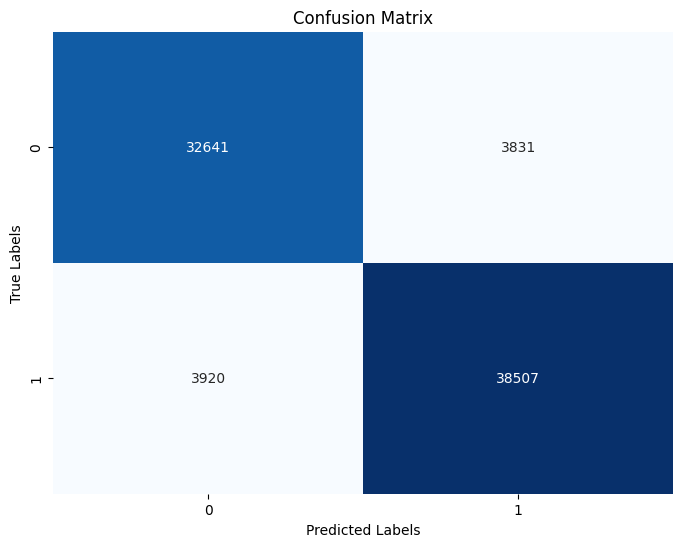

['mlp_model.pkl']

In [8]:
# Predictions with test data
y_pred = mlp_classifier.predict(X_test_vec)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

# Visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Save metrics in a text file
with open("MLP-Report.txt", "w") as file:
    file.write("Accuracy: {:.4f}\n".format(accuracy))
    file.write("Precision: {:.4f}\n".format(precision))
    file.write("Recall: {:.4f}\n".format(recall))
    file.write("F1-score: {:.4f}\n".format(f1))
    file.write("\nClassification Report:\n")
    file.write(class_report)
    file.write("\nConfusion Matrix:\n")
    file.write(np.array2string(conf_matrix, separator=', '))

# Save the trained model
joblib.dump(mlp_classifier, 'mlp_model.pkl')

Validation with Cross-Domain LIAR Data

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.63      0.61      0.62     36472
         1.0       0.67      0.69      0.68     42427

    accuracy                           0.65     78899
   macro avg       0.65      0.65      0.65     78899
weighted avg       0.65      0.65      0.65     78899



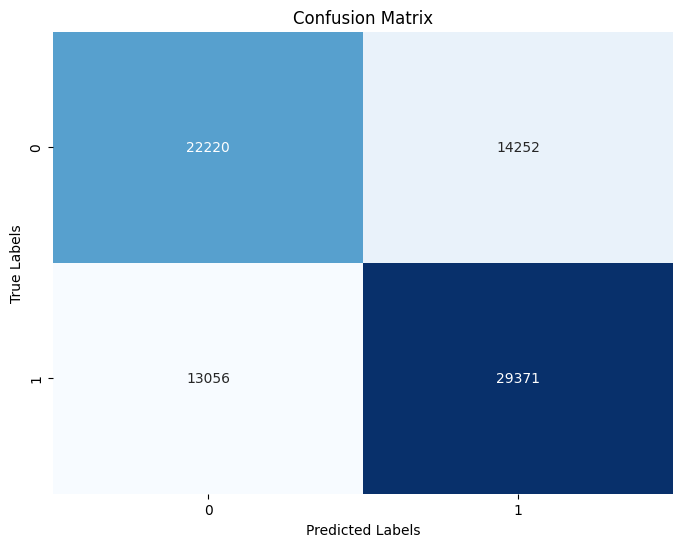

In [9]:
# Load the LIAR Cross-Domain Test data
test_df = pd.read_csv("/kaggle/input/cross-domain-data-liar/labeled-strictness-high-test.tsv", sep='\t', header=None)

# Extract news (X) and labels (y) from the test data
X = test_df[2]  # News Content in column 2
y = test_df[14]  # Label in column 15

# Load the Vectorizer
def custom_tokenizer(text):
    # convert to lowercase, remove punctuation and numeric data, then tokenize
    text = text.lower()
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    tokens = word_tokenize(text)
    return tokens


vectorizer = joblib.load("tfidf_vectorizer.pkl")
X_test_vec = vectorizer.fit_transform(X_test)

# Load the trained model
mlp_classifier = joblib.load('mlp_model.pkl')

# Make predictions with the trained MLPClassifier model
y_pred = mlp_classifier.predict(X_test_vec)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

# Visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Save metrics in a text file
with open("MLP-CrossDomain-Report", "w") as file:
    file.write("Accuracy: {:.4f}\n".format(accuracy))
    file.write("Precision: {:.4f}\n".format(precision))
    file.write("Recall: {:.4f}\n".format(recall))
    file.write("F1-score: {:.4f}\n".format(f1))
    file.write("\nClassification Report:\n")
    file.write(class_report)
    file.write("\nConfusion Matrix:\n")
    file.write(np.array2string(conf_matrix, separator=', '))
